In [92]:
!pip install scikeras

In [93]:
import tensorflow as tf
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense,Input, BatchNormalization, Dropout,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score
import time
from sklearn.preprocessing import StandardScaler

In [94]:
tf.random.set_seed(42)

# 8. Deep Learning

*   a. Build a DNN with five hidden layers of 100 neurons each, He initialization,
and the ELU activation function.

In [95]:
def build_dnn(input_dim, output_units, output_activation):
    model = tf.keras.Sequential([
        Input(shape=(input_dim,)),
        tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(output_units, activation=output_activation)
    ])
    return model


* b. Using Adam optimization and early stopping, try training it on MNIST but
only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the
next exercise. You will need a softmax output layer with five neurons, and as
always make sure to save checkpoints at regular intervals and save the final
model so you can reuse it later.

In [96]:
# Filter MNIST data to keep only target digits
def filter_mnist_data(X, y, target_digits):
    mask = np.isin(y, target_digits)
    X_filtered = X[mask]
    y_filtered = y[mask]
    return X_filtered, y_filtered


In [97]:
# Preprocess data
def preprocess_data(X, y, num_classes):
    # Flatten images to 2D array
    X = X.reshape(X.shape[0], -1)

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Normalize labels to start from 0
    y_normalized = y - y.min()

    # One-hot encode the labels
    y_encoded = to_categorical(y_normalized, num_classes)

    return X_scaled, y_encoded


In [98]:
# Dataset MNIST
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
# Dataset filter
target_digits = [0, 1, 2, 3, 4]
X_train_full, y_train_full = filter_mnist_data(X_train_full, y_train_full, target_digits)
X_test, y_test = filter_mnist_data(X_test, y_test, target_digits)
# Preprocess
X_train_full, y_train_full = preprocess_data(X_train_full, y_train_full, len(target_digits))
X_test, y_test = preprocess_data(X_test, y_test, len(target_digits))

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [99]:
# Model parameters
input_dim = X_train.shape[1]
output_units = len(target_digits)
output_activation = 'softmax'

In [100]:
# Build DNN model
model = build_dnn(input_dim, output_units, output_activation)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [101]:
# Callbacks
checkpoint_path = "dnn_mnist_0_to_4_checkpoint.keras"
final_model_path = "dnn_mnist_0_to_4_final_model.keras"
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)

In [102]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9330 - loss: 0.2403 - val_accuracy: 0.9775 - val_loss: 0.0857
Epoch 2/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9829 - loss: 0.0579 - val_accuracy: 0.9770 - val_loss: 0.0947
Epoch 3/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9880 - loss: 0.0391 - val_accuracy: 0.9810 - val_loss: 0.0740
Epoch 4/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9924 - loss: 0.0261 - val_accuracy: 0.9830 - val_loss: 0.0993
Epoch 5/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9916 - loss: 0.0258 - val_accuracy: 0.9853 - val_loss: 0.0666
Epoch 6/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9949 - loss: 0.0180 - val_accuracy: 0.9853 - val_loss: 0.0796
Epoch 7/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9948 - loss: 0.0161 - val_accuracy: 0.9840 - val_loss: 0.0783
Epoch 8/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9964 - loss: 0.0144 - val_accuracy

In [103]:
# Save final model
model.save(final_model_path)
print(final_model_path)

dnn_mnist_0_to_4_final_model.keras


In [104]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.9872


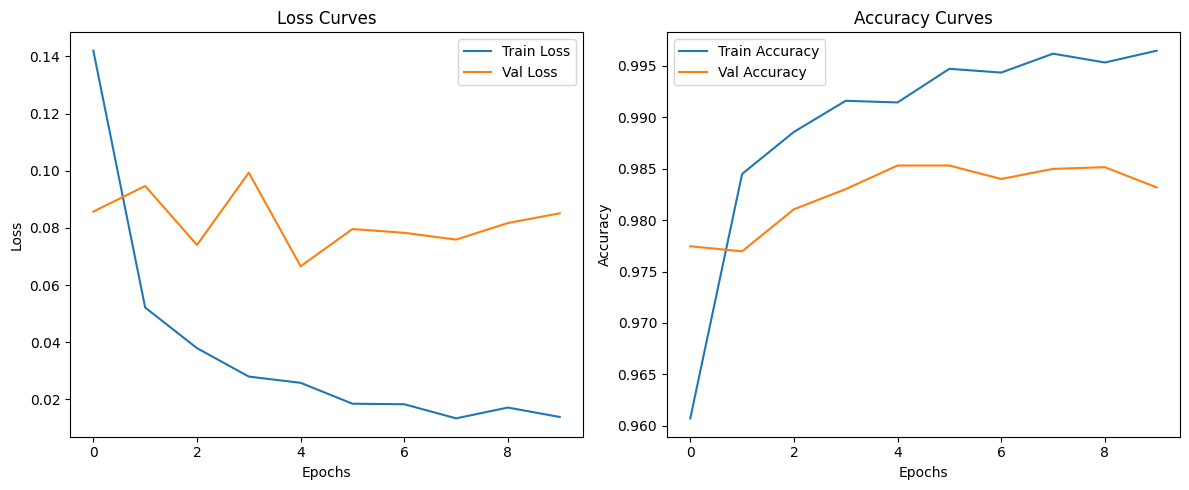

In [105]:
# Plotting Learning Curves
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


*   c. Tune the hyperparameters using cross-validation and see what precision you
can achieve.

In [106]:
def build_dnn(input_dim, output_units, learning_rate, n_neurons):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(n_neurons, activation='elu', kernel_initializer='he_normal'),
        Dense(n_neurons, activation='elu', kernel_initializer='he_normal'),
        Dense(n_neurons, activation='elu', kernel_initializer='he_normal'),
        Dense(n_neurons, activation='elu', kernel_initializer='he_normal'),
        Dense(n_neurons, activation='elu', kernel_initializer='he_normal'),
        Dense(output_units, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



In [107]:
keras_clf = KerasClassifier(
    model=build_dnn,
    input_dim=X_train.shape[1],
    output_units=len(target_digits),
    epochs=20,
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor='accuracy',
            patience=5,
            restore_best_weights=True
        )
    ]
)

In [108]:
# Define hyperparameter grid
param_grid = {
    'batch_size': [32, 64],
    'model__learning_rate': [1e-3, 5e-4, 1e-4],
    'model__n_neurons': [100],
}


In [109]:
#GridSearchCV
grid_search = GridSearchCV(
    estimator=keras_clf,
    param_grid = param_grid,
    cv=5, # 5-fold cross-validation
    scoring='accuracy',
    verbose=1
)

In [110]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Epoch 1/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9348 - loss: 0.2314
Epoch 2/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9817 - loss: 0.0638
Epoch 3/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9902 - loss: 0.0377
Epoch 4/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9899 - loss: 0.0375
Epoch 5/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9953 - loss: 0.0158
Epoch 6/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9928 - loss: 0.0238
Epoch 7/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9928 - loss: 0.0231
Epoch 8/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9960 - loss: 0.0115
Epoch 9/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9952 - loss: 0.0184
Epoch 10/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9954 - loss: 0.0150
Epoch 11/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9970 - los

GridSearchCV(cv=5,
             estimator=KerasClassifier(callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7b7cad7eb2b0>], epochs=20, input_dim=784, model=<function build_dnn at 0x7b7caef9fc70>, output_units=5),
             param_grid={'batch_size': [32, 64],
                         'model__learning_rate': [0.001, 0.0005, 0.0001],
                         'model__n_neurons': [100]},
             scoring='accuracy', verbose=1)

In [111]:
print("Best parameters:", grid_search.best_params_)
print("Best accuracy score:", grid_search.best_score_)

Best parameters: {'batch_size': 32, 'model__learning_rate': 0.001, 'model__n_neurons': 100}
Best accuracy score: 0.9878656525599686


In [112]:
# Evaluate the best model on the test set
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

final_model = best_model.model_

In [113]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)

time_start = time.time()
# Train the model
history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=grid_search.best_params_['batch_size'],
    callbacks=[early_stopping, model_checkpoint]
)
time_end = time.time()
elapsed_time = time_end - time_start
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Epoch 1/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9980 - loss: 0.0090 - val_accuracy: 0.9851 - val_loss: 0.0866
Epoch 2/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9968 - loss: 0.0091 - val_accuracy: 0.9874 - val_loss: 0.0726
Epoch 3/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9982 - loss: 0.0091 - val_accuracy: 0.9855 - val_loss: 0.0856
Epoch 4/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9974 - loss: 0.0083 - val_accuracy: 0.9868 - val_loss: 0.0819
Epoch 5/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 0.9881 - val_loss: 0.0700
Epoch 6/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9986 - loss: 0.0054 - val_accuracy: 0.9876 - val_loss: 0.0815
Epoch 7/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9979 - loss: 0.0114 - val_accuracy: 0.9853 - val_loss: 0.0968
Epoch 8/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9971 - loss: 0.0099 - val_accuracy: 0.

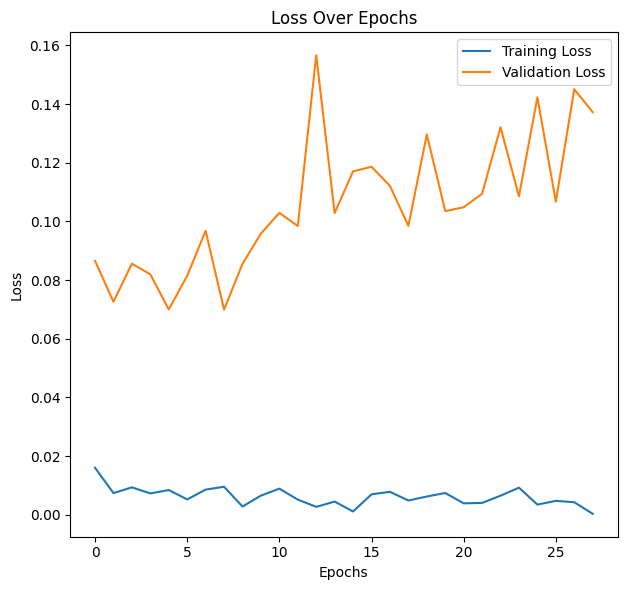

In [114]:
# Plotting Learning Curves
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [115]:
accuracy = model.evaluate(X_test, y_test)
accuracy_train = model.evaluate(X_train, y_train)
print("Test accuracy:", accuracy[1])
print("Train accuracy:", accuracy_train[1])

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9864 - loss: 0.0769
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9954 - loss: 0.0160
Test accuracy: 0.9871570467948914
Train accuracy: 0.9955875277519226


* d. Now try adding Batch Normalization and compare the learning curves: is it
converging faster than before? Does it produce a better model?

In [116]:
def build_dnn_with_batch_norm(input_dim, output_units, output_activation, n_neurons, learning_rate):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Input layer

    # Add hidden layers with Batch Normalization
    for _ in range(5):  # 5 layers as per requirement
        model.add(Dense(n_neurons, activation='elu', kernel_initializer='he_normal'))
        model.add(BatchNormalization())

    # Output layer
    model.add(Dense(output_units, activation=output_activation))

    # Compile the model with the specified learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [117]:
time_start = time.time()
model = build_dnn_with_batch_norm(X_train.shape[1], len(target_digits), 'softmax', grid_search.best_params_['model__n_neurons'], grid_search.best_params_['model__learning_rate'])  # Build the model
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=grid_search.best_params_['batch_size'],
    callbacks=[early_stopping, model_checkpoint]
)
time_end = time.time()
time_elapsed_with_batch = time_end - time_start
print(f"Elapsed time with Batch Normalization: {time_elapsed_with_batch:.2f} seconds")

Epoch 1/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9188 - loss: 0.2511 - val_accuracy: 0.9799 - val_loss: 0.0771
Epoch 2/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9805 - loss: 0.0637 - val_accuracy: 0.9806 - val_loss: 0.0706
Epoch 3/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9904 - loss: 0.0336 - val_accuracy: 0.9835 - val_loss: 0.0758
Epoch 4/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9927 - loss: 0.0231 - val_accuracy: 0.9828 - val_loss: 0.0830
Epoch 5/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9920 - loss: 0.0247 - val_accuracy: 0.9853 - val_loss: 0.0707
Epoch 6/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9948 - loss: 0.0147 - val_accuracy: 0.9861 - val_loss: 0.0778
Epoch 7/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9956 - loss: 0.0130 - val_accuracy: 0.9820 - val_loss: 0.1019
Epoch 8/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9937 - loss: 0.0165 - val_accuracy: 0.

In [118]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9980
Test Accuracy: 0.9893


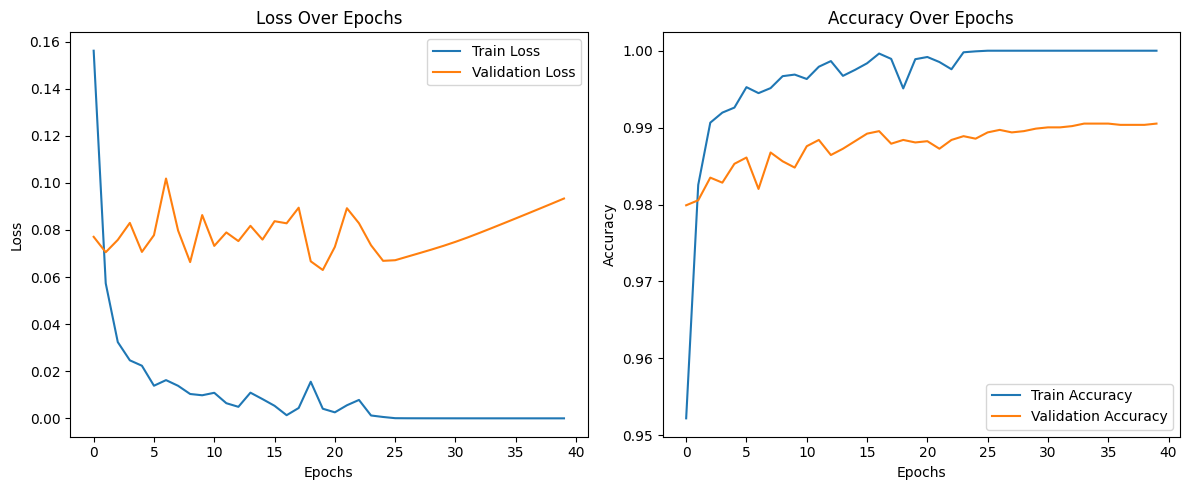

In [119]:
# Plot Learning Curves
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [120]:
# Compare the two models
print(f"Elapsed time without Batch Normalization: {elapsed_time:.2f} seconds")
print(f"Elapsed time with Batch Normalization: {time_elapsed_with_batch:.2f} seconds")
test_accuracy_without_batch = accuracy[1]
test_accuracy_with_batch = test_accuracy
print(f"Test Accuracy without Batch Normalization: {test_accuracy_without_batch:.4f}")
print(f"Test Accuracy with Batch Normalization: {test_accuracy_with_batch:.4f}")

Elapsed time without Batch Normalization: 133.13 seconds
Elapsed time with Batch Normalization: 247.65 seconds
Test Accuracy without Batch Normalization: 0.9872
Test Accuracy with Batch Normalization: 0.9893


Batch Normalization slightly increased training time due to additional computations but improved test accuracy. This shows Batch Normalization stabilizes learning, reduces overfitting, and allows the model to generalize better. Despite the minor trade-off in training time, the accuracy gains make it beneficial for tasks prioritizing performance over speeed

* e. Is the model overfitting the training set? Try adding dropout to every layer
and try again. Does it help?

In [121]:
def build_dnn_with_dropout(input_dim, output_units, output_activation, n_neurons, learning_rate, dropout_rate=0.2):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Input layer

    # Add hidden layers with Batch Normalization and Dropout
    for _ in range(5):  # 5 layers as per requirement
        model.add(Dense(n_neurons, activation='elu', kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))  # Add Dropout layer

    # Output layer
    model.add(Dense(output_units, activation=output_activation))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [122]:
model_with_dropout = build_dnn_with_dropout(X_train.shape[1],
                               len(target_digits),
                               'softmax',
                               grid_search.best_params_['model__n_neurons'],
                               grid_search.best_params_['model__learning_rate'])  # Build the model

In [123]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)

In [124]:
time_start = time.time()
# Train the model
history = model_with_dropout.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=grid_search.best_params_['batch_size'],
    callbacks=[early_stopping, model_checkpoint]
)
time_end = time.time()

Epoch 1/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8634 - loss: 0.4146 - val_accuracy: 0.9721 - val_loss: 0.0938
Epoch 2/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9599 - loss: 0.1399 - val_accuracy: 0.9755 - val_loss: 0.0772
Epoch 3/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9681 - loss: 0.1030 - val_accuracy: 0.9773 - val_loss: 0.0792
Epoch 4/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9741 - loss: 0.0833 - val_accuracy: 0.9824 - val_loss: 0.0647
Epoch 5/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9791 - loss: 0.0658 - val_accuracy: 0.9822 - val_loss: 0.0642
Epoch 6/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9815 - loss: 0.0568 - val_accuracy: 0.9837 - val_loss: 0.0687
Epoch 7/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9835 - loss: 0.0516 - val_accuracy: 0.9835 - val_loss: 0.0729
Epoch 8/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9863 - loss: 0.0413 - val_accuracy:

In [125]:
test_accuracy_with_dropout = model_with_dropout.evaluate(X_test, y_test, verbose=0)[1]
train_accuracy_with_dropout = model_with_dropout.evaluate(X_train, y_train, verbose=0)[1]
print(f"Train Accuracy with Dropout: {train_accuracy_with_dropout:.4f}")
print(f"Test Accuracy with Dropout: {test_accuracy_with_dropout:.4f}")
time_elapsed_with_dropout = time_end - time_start
print(f"Elapsed time with Dropout: {time_elapsed_with_dropout:.2f} seconds")

Train Accuracy with Dropout: 0.9971
Test Accuracy with Dropout: 0.9899
Elapsed time with Dropout: 274.48 seconds


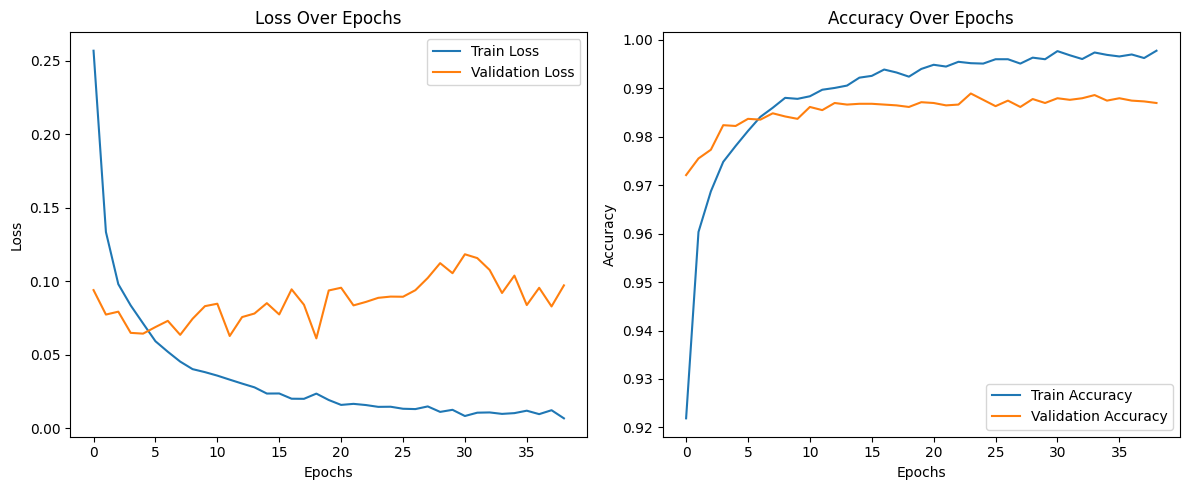

In [126]:
# Plot Learning Curves
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [127]:
# Compare the tree models
print(f"Elapsed time without Batch Normalization: {elapsed_time:.2f} seconds")
print(f"Elapsed time with Batch Normalization: {time_elapsed_with_batch:.2f} seconds")
print(f"Elapsed time with Dropout: {time_elapsed_with_dropout:.2f} seconds")
print(f"Test Accuracy without Batch Normalization: {test_accuracy_without_batch:.4f}")
print(f"Test Accuracy with Batch Normalization: {test_accuracy_with_batch:.4f}")
print(f"Test Accuracy with Dropout: {test_accuracy_with_dropout:.4f}")

Elapsed time without Batch Normalization: 133.13 seconds
Elapsed time with Batch Normalization: 247.65 seconds
Elapsed time with Dropout: 274.48 seconds
Test Accuracy without Batch Normalization: 0.9872
Test Accuracy with Batch Normalization: 0.9893
Test Accuracy with Dropout: 0.9899


In [128]:
model_with_dropout.save(final_model_path)

The results demonstrate that while adding Batch Normalization and Dropout increased the training time, they contributed to marginal improvements in test accuracy, suggesting better generalization. Without Batch Normalization, the model achieved a strong test accuracy , but Batch Normalization slightly improved this , likely due to more stable and faster convergence during training. Incorporating Dropout further boosted the accuracy, indicating its effectiveness in mitigating overfitting. However, this improvement came at the cost of training time. The trade-off between accuracy gains and computational efficiency should be considered based on the application's requirements.

# 9. Transfer learning.

* a. Create a new DNN that reuses all the pretrained hidden layers of the previous
model, freezes them, and replaces the softmax output layer with a fresh new
one.

In [129]:
pretrained_model = tf.keras.models.load_model(final_model_path)

In [130]:
for layer in pretrained_model.layers[:-1]:  # Freeze all layers except the output layer
    layer.trainable = False

In [131]:
target_digits = [5, 6, 7, 8, 9]  # Digits 5 to 9

In [132]:
# Build a new Sequential model
new_sequential_model = Sequential()
# Add all layers from the pretrained model except the output layer
for layer in pretrained_model.layers[:-1]:
    new_sequential_model.add(layer)

# Add a new output layer with 5 units (one for each digit)
new_sequential_model.add(Dense(len(target_digits), activation='softmax', name='new_output_layer'))

# Compile
new_sequential_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=grid_search.best_params_['model__learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
new_sequential_model.summary()


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_415 (Dense)                    │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_416 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_417 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_418 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_419 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_output_layer (Dense)             │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,900 (472.27 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 120,900 (472.27 KB)

In [133]:
# Dummy input to force the model to build the new layer
dummy_input = tf.random.normal([1, X_train.shape[1]])
# Call the model with the dummy input
new_sequential_model(dummy_input)
# Verify that the new layer has been added
new_sequential_model.summary()


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_415 (Dense)                    │ (1, 100)                    │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (1, 100)                    │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (1, 100)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_416 (Dense)                    │ (1, 100)                    │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (1, 100)                    │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (1, 100)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_417 (Dense)                    │ (1, 100)                    │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (1, 100)                    │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (1, 100)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_418 (Dense)                    │ (1, 100)                    │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (1, 100)                    │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (1, 100)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_419 (Dense)                    │ (1, 100)                    │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (1, 100)                    │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (1, 100)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_output_layer (Dense)             │ (1, 5)                      │             505 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,405 (474.24 KB)

 Trainable params: 505 (1.97 KB)

 Non-trainable params: 120,900 (472.27 KB)

In [134]:
model_c_path = "dnn_mnist_0_to_4_model_c.keras"
model_checkpoint = ModelCheckpoint(model_c_path, save_best_only=True)
model_c = new_sequential_model.save(model_c_path)

*   b. Train this new DNN on digits 5 to 9, using only 100 images per digit, and time
how long it takes. Despite this small number of examples, can you achieve
high precision?

In [135]:
# Filter examples per digit
def filter_example_per_digit(X, y, examples_per_digit):
    X_filtered = []
    y_filtered = []

    for digit in np.unique(y):
        # Filter examples for the current digit
        mask = (y == digit)
        X_digit = X[mask]
        y_digit = y[mask]

        # Ensure sufficient examples for sampling
        if len(X_digit) >= examples_per_digit:
            indices = np.random.choice(len(X_digit), examples_per_digit, replace=False)
            X_filtered.append(X_digit[indices])
            y_filtered.append(y_digit[indices])
        else:
            raise ValueError(f"Not enough examples for digit {digit}.")

    # Combine all filtered data
    X_filtered = np.vstack(X_filtered)
    y_filtered = np.hstack(y_filtered)

    #Shuffle data to remove any ordering bias
    shuffle_indices = np.arange(X_filtered.shape[0])
    np.random.shuffle(shuffle_indices)

    return X_filtered[shuffle_indices], y_filtered[shuffle_indices]


In [136]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data() # Load dataset

In [137]:
target_digits = [5, 6, 7, 8, 9]

In [138]:
X_test, y_test = filter_mnist_data(X_test, y_test, target_digits)
X_test, y_test = preprocess_data(X_test, y_test, len(target_digits))

In [139]:
# Apply filtering before preprocessing
X_train_filtered, y_train_filtered = filter_mnist_data(X_train_full, y_train_full, target_digits)
X_train_filtered, y_train_filtered = filter_example_per_digit(X_train_filtered, y_train_filtered, 100)
# Apply preprocessing
X_train_processed, y_train_processed = preprocess_data(X_train_filtered, y_train_filtered, len(target_digits))


In [140]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)


In [141]:
time_start = time.time()
# Train the model with EarlyStopping
history = new_sequential_model.fit(
    X_train_processed,
    y_train_processed,
    validation_split=0.3,
    epochs=50,
    batch_size=grid_search.best_params_['batch_size'],
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
time_end = time.time()

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1445 - loss: 1.9998 - val_accuracy: 0.2200 - val_loss: 1.5912
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2242 - loss: 1.7470 - val_accuracy: 0.3733 - val_loss: 1.3615
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3619 - loss: 1.5198 - val_accuracy: 0.5267 - val_loss: 1.1952
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3843 - loss: 1.4338 - val_accuracy: 0.6400 - val_loss: 1.0812
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4853 - loss: 1.2625 - val_accuracy: 0.6667 - val_loss: 1.0077
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4968 - loss: 1.2433 - val_accuracy: 0.6667 - val_loss: 0.9577
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5559 - loss: 1.1114 - val_accuracy: 0.7000 - val_loss: 0.9203
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5278 - loss: 1.1361 - val_accuracy: 0.7267 - v

In [142]:
accuracy_b = new_sequential_model.evaluate(X_test, y_test)

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7046 - loss: 0.8341


In [143]:
print("Test accuracy:", accuracy_b[1])

Test accuracy: 0.7354453802108765


In [144]:
def plot_metrics(history):
    # Extract metrics from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history.get('accuracy')
    val_accuracy = history.history.get('val_accuracy')

    # Create figure
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy (if available)
    if accuracy and val_accuracy:
        plt.subplot(1, 2, 2)
        plt.plot(accuracy, label='Training Accuracy')
        plt.plot(val_accuracy, label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()

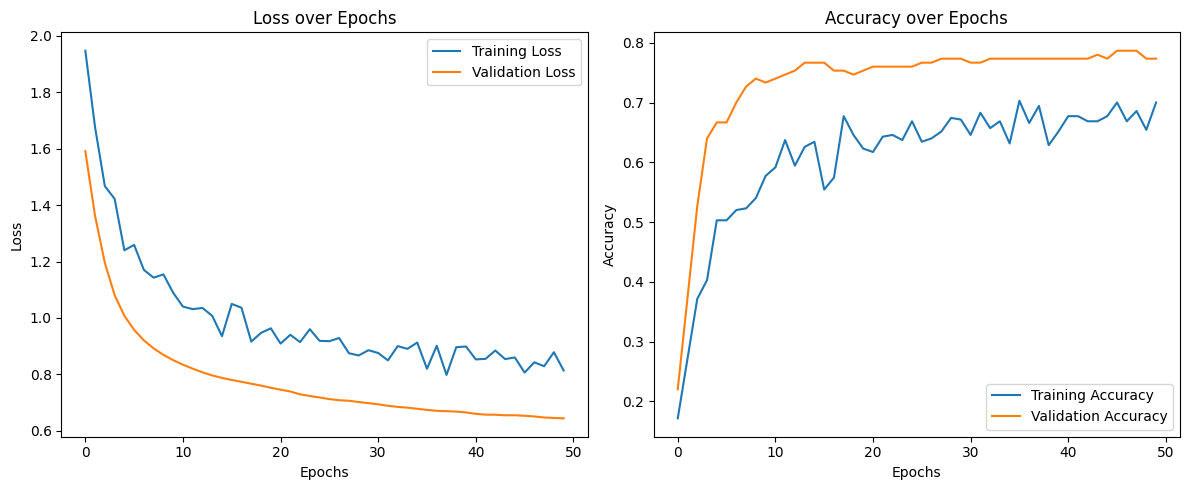

In [145]:
plot_metrics(history)

In [146]:
compute_time= time_end - time_start
print(f"Elapsed time: {compute_time:.2f} seconds")

Elapsed time: 11.76 seconds


* d. Try again reusing just four hidden layers instead of five. Can you achieve a
higher precision?

In [147]:
base_model = tf.keras.models.load_model(final_model_path)

In [148]:
new_sequential_model = Sequential()
new_sequential_model.add(Input(shape=(X_train.shape[1],)))  # Input layer
# Add all layers from the pretrained model except the output layer and the second last layer
for layer in base_model.layers[:-2]:
    layer.trainable = False # Freeze pretrained layers
    new_sequential_model.add(layer)

In [149]:
new_sequential_model.add(Dense(100, activation='elu', kernel_initializer='he_normal')) #Add the trainable second last layer
new_sequential_model.add(BatchNormalization())  # Add Batch Normalization
new_sequential_model.add(Dropout(0.2))  # Add Dropout layer

In [150]:
new_sequential_model.add(Dense(len(target_digits), activation='softmax', name='new_output_layer')) #add the output layer

In [151]:
new_sequential_model.summary()

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_415 (Dense)                    │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_416 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_417 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_418 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_419 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_421 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_output_layer (Dense)             │ (None, 5)                   │             505 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 131,905 (515.25 KB)

 Trainable params: 10,805 (42.21 KB)

 Non-trainable params: 121,100 (473.05 KB)

In [152]:
new_sequential_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=grid_search.best_params_['model__learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [153]:
time_start = time.time()
# Train the model with EarlyStopping
history = new_sequential_model.fit(
    X_train_processed,
    y_train_processed,
    validation_split=0.3,
    epochs=50,
    batch_size=grid_search.best_params_['batch_size'],
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
time_end = time.time()

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2836 - loss: 1.8732 - val_accuracy: 0.5200 - val_loss: 1.1136
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5689 - loss: 1.2019 - val_accuracy: 0.5867 - val_loss: 0.9934
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6095 - loss: 1.0697 - val_accuracy: 0.6333 - val_loss: 0.8985
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6218 - loss: 1.0089 - val_accuracy: 0.6467 - val_loss: 0.8461
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6286 - loss: 0.9303 - val_accuracy: 0.6600 - val_loss: 0.8110
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6518 - loss: 0.9195 - val_accuracy: 0.6867 - val_loss: 0.7361
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6407 - loss: 0.9978 - val_accuracy: 0.7267 - val_loss: 0.6951
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6450 - loss: 0.8488 - val_accuracy: 0.7333 - val_loss

In [154]:
accuracy_d = new_sequential_model.evaluate(X_test, y_test)
print("Test accuracy:", accuracy_d[1])

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7566 - loss: 0.7310
Test accuracy: 0.7870808243751526


In [155]:
time_elapsed = time_end - time_start
print(f"Elapsed time : {time_elapsed:.2f} seconds")

Elapsed time : 12.53 seconds


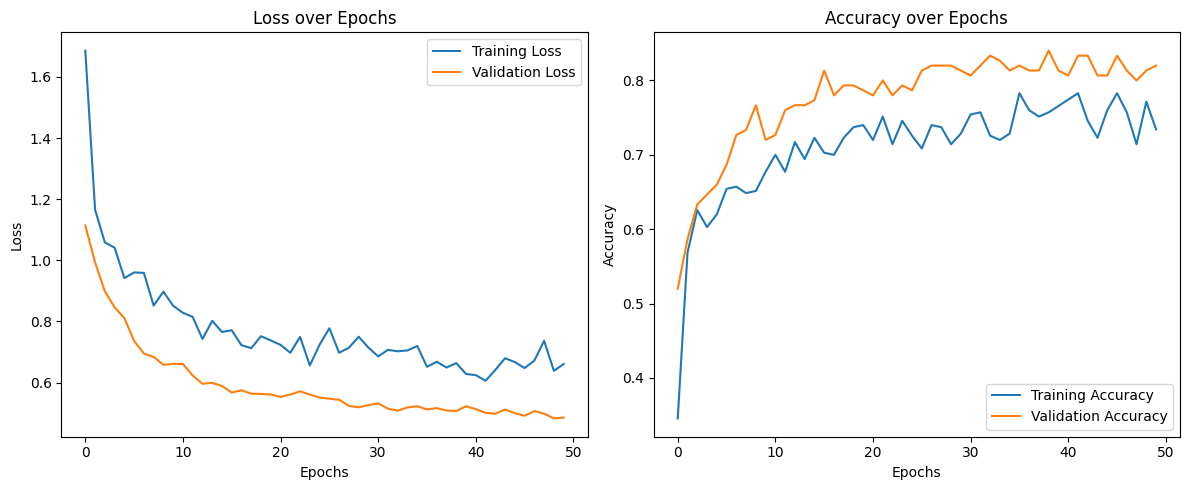

In [156]:
plot_metrics(history)

*  e. Now unfreeze the top two hidden layers and continue training: can you get
the model to perform even better?

In [157]:
base_model = tf.keras.models.load_model(model_c_path)

In [158]:
base_model.layers

[<Dense name=dense_415, built=True>,
 <BatchNormalization name=batch_normalization_16, built=True>,
 <Dropout name=dropout_6, built=True>,
 <Dense name=dense_416, built=True>,
 <BatchNormalization name=batch_normalization_17, built=True>,
 <Dropout name=dropout_7, built=True>,
 <Dense name=dense_417, built=True>,
 <BatchNormalization name=batch_normalization_18, built=True>,
 <Dropout name=dropout_8, built=True>,
 <Dense name=dense_418, built=True>,
 <BatchNormalization name=batch_normalization_19, built=True>,
 <Dropout name=dropout_9, built=True>,
 <Dense name=dense_419, built=True>,
 <BatchNormalization name=batch_normalization_20, built=True>,
 <Dense name=dense_421, built=True>,
 <BatchNormalization name=batch_normalization_21, built=True>,
 <Dropout name=dropout_11, built=True>,
 <Dense name=new_output_layer, built=True>]

In [159]:
base_model.summary()


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_415 (Dense)                    │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_416 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_417 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_418 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_419 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_421 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_output_layer (Dense)             │ (None, 5)                   │             505 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 153,517 (599.68 KB)

 Trainable params: 10,805 (42.21 KB)

 Non-trainable params: 121,100 (473.05 KB)

 Optimizer params: 21,612 (84.43 KB)

In [160]:
# Unfreeze the top two hidden layers
for layer in base_model.layers[-7:]:
    layer.trainable = True

In [161]:
base_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=grid_search.best_params_['model__learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [162]:
checkpoint_path = "dnn_mnist_0_to_4_fine_tuned_checkpoint.keras"
fine_tuned_model_path = "dnn_mnist_0_to_4_fine_tuned_model.keras"
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, save_best_only=True)

In [163]:
time_start = time.time()
# Train the model with EarlyStopping
history = base_model.fit(
    X_train_processed,
    y_train_processed,
    validation_split=0.3,
    epochs=50,
    batch_size=grid_search.best_params_['batch_size'],
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
time_end = time.time()

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7353 - loss: 0.6997 - val_accuracy: 0.7933 - val_loss: 0.5258
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7606 - loss: 0.6440 - val_accuracy: 0.8067 - val_loss: 0.5124
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7515 - loss: 0.6706 - val_accuracy: 0.8067 - val_loss: 0.5028
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7452 - loss: 0.6488 - val_accuracy: 0.8067 - val_loss: 0.4926
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7933 - loss: 0.5566 - val_accuracy: 0.8133 - val_loss: 0.4994
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7610 - loss: 0.6329 - val_accuracy: 0.7933 - val_loss: 0.5019
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7624 - loss: 0.6552 - val_accuracy: 0.8067 - val_loss: 0.4877
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7655 - loss: 0.5932 - val_accuracy: 0.8267 - val

In [164]:
time_elapsed = time_end - time_start
print(f"Elapsed time : {time_elapsed:.2f} seconds")

Elapsed time : 12.46 seconds


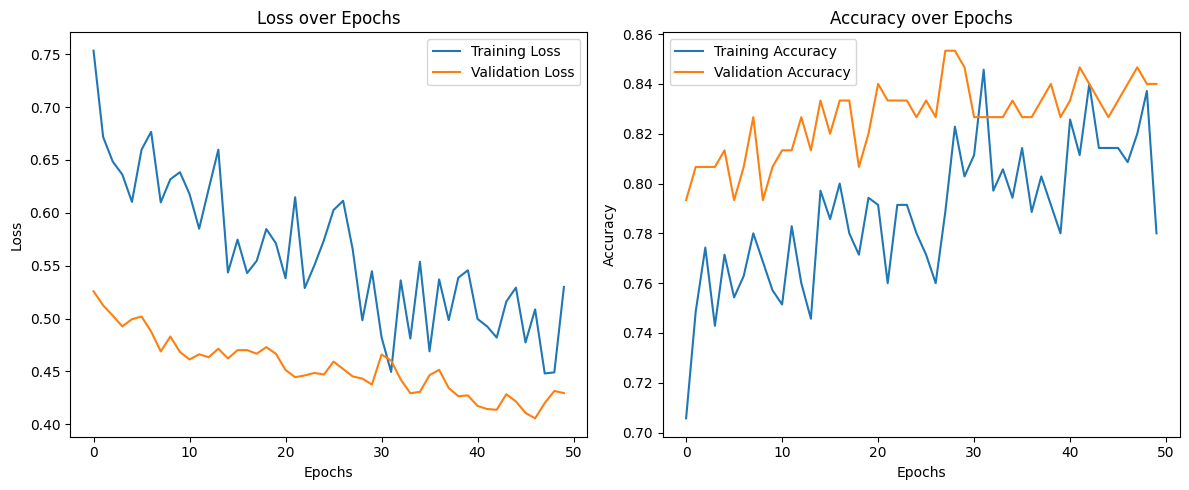

In [165]:
plot_metrics(history)

In [166]:
accuracy_e = base_model.evaluate(X_test, y_test)
print("Test accuracy:", accuracy_e[1])

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7901 - loss: 0.6642
Test accuracy: 0.8169100880622864


In [167]:
# Comparing the results
accuracy = [accuracy_b[1], accuracy_d[1], accuracy_e[1]]
print(f"Accuracy with 5 freezen layers:{accuracy[0]:.4f}")
print(f"Accuracy with 4 freezen layers:{accuracy[1]:.4f}")
print(f"Accuracy with 3 freezen layers:{accuracy[2]:.4f}")

Accuracy with 5 freezen layers:0.7354
Accuracy with 4 freezen layers:0.7871
Accuracy with 3 freezen layers:0.8169


The results show that freezing the early layers, which capture general low-level features, had less impact on performance, as they are more universal across tasks. However, freezing deeper layers, which are more task-specific, limited the model's ability to adapt to the specific problem, resulting in lower accuracy. Unfreezing these deeper layers allowed the model to fine-tune its task-specific features, leading to improved accuracy as the layers became more specialized for the task.

# 10. Pretraining on an auxiliary task.

* a. In this exercise you will build a DNN that compares two MNIST digit images
and predicts whether they represent the same digit or not. Then you will reuse
the lower layers of this network to train an MNIST classifier using very little
training data. Start by building two DNNs (let’s call them DNN A and B), both
similar to the one you built earlier but without the output layer: each DNN
should have five hidden layers of 100 neurons each, He initialization, and ELU
activation. Next, add a single output layer on top of both DNNs. You should
use TensorFlow’s concat() function with axis=1 to concatenate the outputs
of both DNNs along the horizontal axis, then feed the result to the output
layer. This output layer should contain a single neuron using the logistic acti‐
vation function.

In [168]:
# Function DNN
def build_dnn(input_shape, name):
    model = tf.keras.Sequential(name=name)
    model.add(tf.keras.layers.InputLayer(shape=input_shape))
    for _ in range(5):
        model.add(tf.keras.layers.Dense(100, activation="elu", kernel_initializer=tf.keras.initializers.HeNormal()))
    return model

In [169]:
# input shape
n_inputs = X_train.shape[-1]
input_shape = (n_inputs,)

In [170]:
# Create the 2 DNN
dnn_a = build_dnn(input_shape, name="DNN_A")
dnn_b = build_dnn(input_shape, name="DNN_B")

In [171]:
# input
input_images = tf.keras.Input(shape=(2, n_inputs), name="X")

In [172]:
x1, x2 = tf.keras.layers.Lambda(lambda x: tf.unstack(x, axis=1))(input_images) # Use Lambda layer to split the input tensor into two separate tensors,`x1` for the first image and `x2` for the second image

In [173]:
# Pass the first image through the first DNN and the second image through the second DNN
dnn_a_output = dnn_a(x1)
dnn_b_output = dnn_b(x2)

In [174]:
concatenated = tf.keras.layers.Concatenate(axis=1)([dnn_a_output, dnn_b_output]) ## Concatenate the outputs of the two DNNs along the feature axis (axis=1)

hidden = tf.keras.layers.Dense(10, activation="elu", kernel_initializer=tf.keras.initializers.HeNormal())(concatenated)
output = tf.keras.layers.Dense(1, activation="sigmoid", kernel_initializer=tf.keras.initializers.HeNormal())(hidden)

model = tf.keras.Model(inputs=input_images, outputs=output, name="Siamese_DNN")

In [175]:
model.compile(
    optimizer="Adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [176]:
model.summary()

Model: "Siamese_DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ X (InputLayer)            │ (None, 2, 784)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ [(None, 784), (None,   │              0 │ X[0][0]                │
│                           │ 784)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DNN_A (Sequential)        │ (None, 100)            │        118,900 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DNN_B (Sequential)        │ (None, 100)            │        118,900 │ lambda_1[0][1]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 200)            │              0 │ DNN_A[0][0],           │
│ (Concatenate)             │                        │                │ DNN_B[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_432 (Dense)         │ (None, 10)             │          2,010 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_433 (Dense)         │ (None, 1)              │             11 │ dense_432[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 239,821 (936.80 KB)

 Trainable params: 239,821 (936.80 KB)

 Non-trainable params: 0 (0.00 B)

* b. Split the MNIST training set in two sets: split #1 should containing 55,000
images, and split #2 should contain contain 5,000 images. Create a function
that generates a training batch where each instance is a pair of MNIST images
picked from split #1. Half of the training instances should be pairs of images
that belong to the same class, while the other half should be images from dif‐
ferent classes. For each pair, the training label should be 0 if the images are
from the same class, or 1 if they are from different classes.

Split the dataset

In [194]:
# Load MNIST dataset
(X_train_full, y_train_full), (_, _) = tf.keras.datasets.mnist.load_data()

# Preprocess
X_train_full,_ = preprocess_data(X_train_full, y_train_full, 10)
# Split dataset into two sets
split_1_size = 55000
X_train1, y_train1 = X_train_full[:split_1_size], y_train_full[:split_1_size]
X_train2, y_train2 = X_train_full[split_1_size:], y_train_full[split_1_size:]

Function to Generate Training Batches

In [196]:
def generate_batch(images, labels, batch_size):
    half_batch = batch_size // 2
    X_batch = []
    y_batch = []

    while len(X_batch) < half_batch:
        idx1, idx2 = np.random.choice(len(images), size=2, replace=False)
        if labels[idx1] == labels[idx2]:
            X_batch.append([images[idx1], images[idx2]])
            y_batch.append(1)

    while len(X_batch) < batch_size:
        idx1, idx2 = np.random.choice(len(images), size=2, replace=False)
        if labels[idx1] != labels[idx2]:
            X_batch.append([images[idx1], images[idx2]])
            y_batch.append(0)

    X_batch = np.array(X_batch)
    y_batch = np.array(y_batch).reshape(-1, 1)
    rnd_indices = np.random.permutation(batch_size)

    return X_batch[rnd_indices], y_batch[rnd_indices]


In [197]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

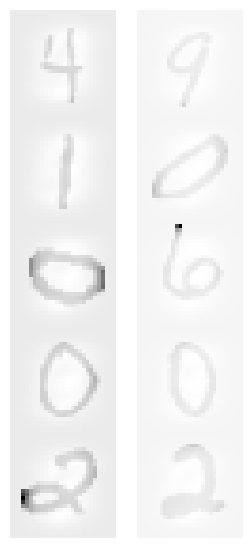

In [198]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

In [181]:
y_batch

array([[0],
       [0],
       [1],
       [0],
       [1]])